In [1]:
# Activate project enviroment 
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Library/Mobile Documents/com~apple~CloudDocs/Master/Applied Mathematical Optimization/Project/Git/AMO_Project`
┌ Warning: The project dependencies or compat requirements have changed since the manifest was last resolved.
│ It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.
└ @ Pkg.API /Users/julia/.julia/scratchspaces/a66863c6-20e8-4ff4-8a62-49f30b1f605e/agent-cache/default-macmini-x64-6.0/build/default-macmini-x64-6-0/julialang/julia-release-1-dot-8/usr/share/julia/stdlib/v1.8/Pkg/src/API.jl:1532


In [2]:
# die pakete die wir für dieses Notebook brauchen
using JuMP
using Plots
using XLSX
using DataFrames
using Complementarity
using Ipopt
using Distributions
using CSV
using HiGHS
using StatsPlots
using Clustering
using Distances
using LinearAlgebra

## Stochastic Market Clearing Formulation

For the stochastic market clearing a two-stage stochastic programming approach is used. This means, that the day-ahead market and the balancing market are cleared simultaneously, to cooptimize energy and reserve capacity. This simultaneous approach captures the coupling existing between these two commodities and reduces the so-called expected system operation cost (total cost), compared to a sequential approach. 

For the generation of scenarios we consider the Monte Carlo approach. Thus, in the first step, we fit the Weibull distributions to the scenarios (each hour of each wind farm has it's own independent distribution) and then randomly generate scenarios out of these distributions. To get actual wind energy values from the normalized scenarios, we consider the given energy forcast for each wind farm (see table) as the mean of the energy production level over all 43 hours. (i.e. if the mean value of the scenarios would be 0.5 and the energy forcast is 100, we get a factor of 200)

In [3]:
# read in wind data for the aggregated zones 1-4 corresponding to the wind farms 1-4 and remove fist coloum as it contains redundant index.
scenarios = [CSV.read("./data/aggr_zone1.csv", DataFrame),CSV.read("./data/aggr_zone2.csv", DataFrame),CSV.read("./data/aggr_zone3.csv", DataFrame),CSV.read("./data/aggr_zone4.csv", DataFrame)]
c = 1
for i in scenarios
    scenarios[c]= i[:,2:end]
    c = c+1
end
size(scenarios[1])

(43, 100)

### Scenario Generation with Monte Carlo Method

To generate random scenarios, we first fit weibull distributions to every hour in every scone of the dataset.

In [13]:
weibull_distr = [[], [], [], []]

c = 0
for i in scenarios
    c = c+1
    for row in eachrow(i)
        current_hour = Array(row)
        weibull_est = fit_mle(Weibull,current_hour)
        push!(weibull_distr[c], weibull_est)
    end
end

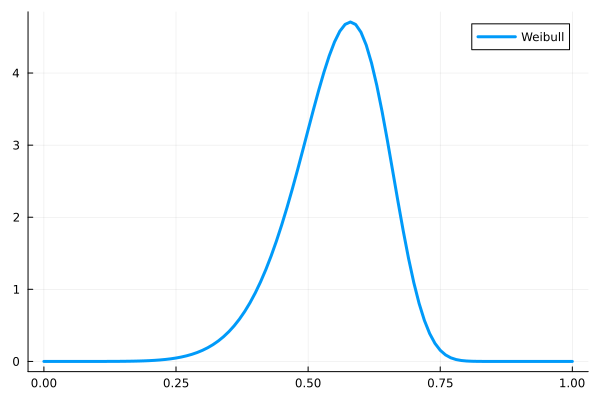

In [26]:
#Plot pdf of Estimations - Exemplary first hour of zone 2
x = 0.0:0.01:1
plot(x,pdf.(weibull_distr[2][1],x),label="Weibull",lw=3)

In [27]:
weibull_distr[2][1]  # Zone 2 hour 1

Weibull{Float64}(α=7.495559487306329, θ=0.5911744138655056)

In [31]:
MonteCarlo_scenarios = [[], [], [], []]

for z in 1:4
    for h in 1:43
        S = 10000
        scenarios = rand.(weibull_distr[z][h], S)'
        push!(MonteCarlo_scenarios[z], scenarios)
    end
end

In [32]:
MonteCarlo_scenarios[2][1]  # Zone 2 hour 1

1×10000 adjoint(::Vector{Float64}) with eltype Float64:
 0.640224  0.549764  0.631303  0.518233  …  0.588796  0.556375  0.625718

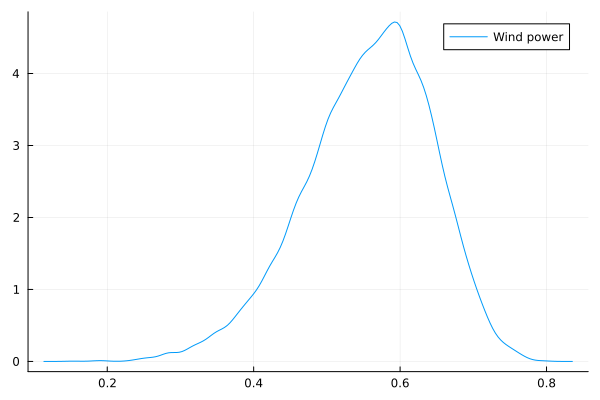

In [34]:
# Exemplary density function of Monte Carlo Scenarios, Exemplary first hour of zone 2
density(MonteCarlo_scenarios[2][1][1,:], bandwidth= 0.01,label="Wind power")    # [row,column]

In [39]:
# Transform the Monte Carlo Scenarios into four DataFrames and save them in one file
Wind_data_scenarios = [(DataFrame(reduce(vcat, MonteCarlo_scenarios[1]), :auto)), (DataFrame(reduce(vcat, MonteCarlo_scenarios[2]), :auto)), 
DataFrame(reduce(vcat, MonteCarlo_scenarios[3]), :auto), (DataFrame(reduce(vcat, MonteCarlo_scenarios[4]), :auto))]

4-element Vector{DataFrame}:
 43×10000 DataFrame
 Row │ x1        x2        x3        x4        x5         x6         x7        ⋯
     │ Float64   Float64   Float64   Float64   Float64    Float64    Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.615116  0.60181   0.550646  0.600934  0.326454   0.454388   0.589879  ⋯
   2 │ 0.741629  0.665886  0.646994  0.668833  0.736526   0.705735   0.545179
   3 │ 0.635554  0.671347  0.714395  0.712411  0.713202   0.754408   0.7571
   4 │ 0.724882  0.754956  0.739843  0.782722  0.774017   0.725696   0.765659
   5 │ 0.6719    0.78875   0.793287  0.731209  0.691093   0.740686   0.707929  ⋯
   6 │ 0.783464  0.628358  0.743724  0.609255  0.776436   0.800299   0.761484
   7 │ 0.754327  0.658969  0.562199  0.715923  0.764235   0.765434   0.791771
   8 │ 0.7243    0.617891  0.716919  0.799957  0.782003   0.749195   0.662735
   9 │ 0.817351  0.743822  0.739918  0.792623  0.771884   0.745543   0.722933  ⋯

In [40]:
# scale the data to fit our model
forecast = [120.54, 115.52, 53.34, 38.16]

counter = 1
for s in Wind_data_scenarios
    factor = forecast[counter]/(mean(mean(MonteCarlo_scenarios[counter])))
    transform!(s,x -> x .* factor)
    counter = counter + 1
end


In [41]:
Wind_data_scenarios

4-element Vector{DataFrame}:
 43×10000 DataFrame
 Row │ x1        x2        x3        x4        x5        x6        x7        x ⋯
     │ Float64   Float64   Float64   Float64   Float64   Float64   Float64   F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 145.282   142.139   130.055   141.932    77.1038  107.32    139.321   1 ⋯
   2 │ 175.162   157.273   152.811   157.969   173.957   166.685   128.763   1
   3 │ 150.109   158.563   168.73    168.261   168.448   178.181   178.816   1
   4 │ 171.207   178.31    174.74    184.868   182.812   171.399   180.838   1
   5 │ 158.693   186.291   187.363   172.701   163.226   174.939   167.203   1 ⋯
   6 │ 185.043   148.409   175.657   143.897   183.383   189.019   179.852   1
   7 │ 178.161   155.639   132.783   169.091   180.501   180.785   187.005   1
   8 │ 171.069   145.937   169.326   188.938   184.698   176.949   156.529   1
   9 │ 193.047   175.68    174.758   187.206   182.308   176.087   170.7

### Scenario Reduction with KMeans

In [94]:
scenarios = copy(Wind_data_scenarios)

reduced_scenarios = [[], [], [], []]
prob_of_scenarios = [[], [], [], []]

c = 0
for r in scenarios
    c = c+1
    zone = r
    i = 0
    for row in eachrow(zone)
        i = i+1
        hour = Array(DataFrame(zone[i, :]))
        km = kmeans(hour, 5)
        centers = km.centers
        prob_scenarios = counts(km) / 10000
        push!(reduced_scenarios[c], centers)
        push!(prob_of_scenarios[c], prob_scenarios)
    end
end

In [95]:
Scenarios_zone1 = (DataFrame(reduce(vcat, reduced_scenarios[1]), :auto))
Scenarios_zone2 = (DataFrame(reduce(vcat, reduced_scenarios[2]), :auto))
Scenarios_zone3 = (DataFrame(reduce(vcat, reduced_scenarios[3]), :auto))
Scenarios_zone4 = (DataFrame(reduce(vcat, reduced_scenarios[4]), :auto))

Row,x1,x2,x3,x4,x5
,Float64,Float64,Float64,Float64,Float64
1,49.695,40.6329,35.8766,29.1061,45.0115
2,52.8842,48.3096,31.686,39.0239,43.9231
3,35.7729,56.4327,47.9695,52.0982,42.9852
4,55.0663,46.0224,38.7643,50.847,59.5954
5,54.8511,39.4904,59.0392,50.7968,46.0616
6,46.0533,50.8773,59.1914,54.9554,39.0327
7,55.4052,59.4861,46.4808,39.754,51.3646
8,50.3729,37.4627,59.5348,45.0125,54.834
9,45.2436,54.5191,50.3007,58.976,37.8493


In [96]:
CSV.write("./data/scenarios/Scenarios_zone1.csv", Scenarios_zone1)
CSV.write("./data/scenarios/Scenarios_zone2.csv", Scenarios_zone2)
CSV.write("./data/scenarios/Scenarios_zone3.csv", Scenarios_zone3)
CSV.write("./data/scenarios/Scenarios_zone4.csv", Scenarios_zone4)

"./data/scenarios/Scenarios_zone4.csv"

In [97]:
Probs_zone1 = (DataFrame(reduce(vcat, prob_of_scenarios[1]'), :auto))
Probs_zone2 = (DataFrame(reduce(vcat, prob_of_scenarios[2]'), :auto))
Probs_zone3 = (DataFrame(reduce(vcat, prob_of_scenarios[3]'), :auto))
Probs_zone4 = (DataFrame(reduce(vcat, prob_of_scenarios[4]'), :auto))

Row,x1,x2,x3,x4,x5
,Float64,Float64,Float64,Float64,Float64
1,0.1697,0.271,0.1845,0.0672,0.3076
2,0.1925,0.3027,0.057,0.1684,0.2794
3,0.0634,0.1802,0.2827,0.2948,0.1789
4,0.3042,0.1722,0.0578,0.275,0.1908
5,0.3177,0.052,0.2056,0.2664,0.1583
6,0.1644,0.2708,0.1997,0.313,0.0521
7,0.2991,0.1782,0.1724,0.0605,0.2898
8,0.2837,0.0541,0.1904,0.1704,0.3014
9,0.1683,0.3139,0.2732,0.1896,0.055


In [98]:
CSV.write("./data/scenarios/Probs_zone1.csv", Probs_zone1)
CSV.write("./data/scenarios/Probs_zone2.csv", Probs_zone2)
CSV.write("./data/scenarios/Probs_zone3.csv", Probs_zone3)
CSV.write("./data/scenarios/Probs_zone4.csv", Probs_zone4)

"./data/scenarios/Probs_zone4.csv"